In [1]:
import pofah.jet_sample as js
import pofah.util.sample_factory as sf
import pofah.util.experiment as ex
import selection.discriminator as dis
import selection.loss_strategy as ls
import analysis.analysis_discriminator as an
import anpofah.util.plotting_util as pu

Welcome to JupyROOT 6.18/04


In [2]:
# read in qcd signal region sample
run_n = 101
qcd_sig_id = 'qcdSigReco'
BSM_samples = ['GtoWW15naReco', 'GtoWW15brReco', 'GtoWW25naReco', 'GtoWW25brReco','GtoWW35naReco', 'GtoWW35brReco', 'GtoWW45naReco', 'GtoWW45brReco']
mjj_key = 'mJJ'
reco_loss_j1_key = 'j1RecoLoss'

In [3]:
experiment = ex.Experiment(run_n)
qcd_sig_data = sf.read_results_to_jet_sample_dict([qcd_sig_id], experiment)

split into discriminator train and test-set

In [4]:
# define quantile and loss-strategy for discimination
quantile = 0.05 # 5%
strategy = ls.combine_loss_min
qcd_sig_sample = qcd_sig_data['qcdSigReco']

In [5]:
print(qcd_sig_sample.features())
# train discriminator (and plot results => TODO)
discriminator = dis.QRDiscriminator(quantile=quantile, loss_strategy=strategy)
discriminator.fit(qcd_sig_sample)

W0812 17:44:40.403965 140218846988096 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96bpython3/x86_64-centos7-gcc9-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']


W0812 17:44:40.736733 140218846988096 deprecation.py:323] From /eos/home-k/kiwoznia/dev/data_driven_anomaly_hunting/dadrah/selection/quantile_regression.py:14: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
_________________________________________________________

2020-08-12 17:44:41.143490: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08-12 17:44:41.168578: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199945000 Hz
2020-08-12 17:44:41.175143: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f49860 executing computations on platform Host. Devices:
2020-08-12 17:44:41.175170: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-08-12 17:44:41.245675: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

In [6]:
# apply selection to datasample
qcd_sig_train_selection = discriminator.select(qcd_sig_sample)
#qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
qcd_sig_sample.add_feature('sel', qcd_sig_train_selection)

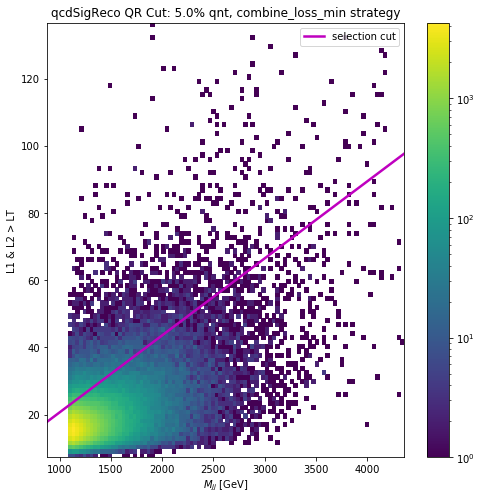

In [7]:
# plot mjj qcd sig to check for flat ratio
an.analyze_discriminator_cut(discriminator, qcd_sig_sample)

plot mjj accepted vs rejected signal to check for mass sculpting

<ROOT.TCanvas object ("c_out_ratio") at 0x8f808d0>

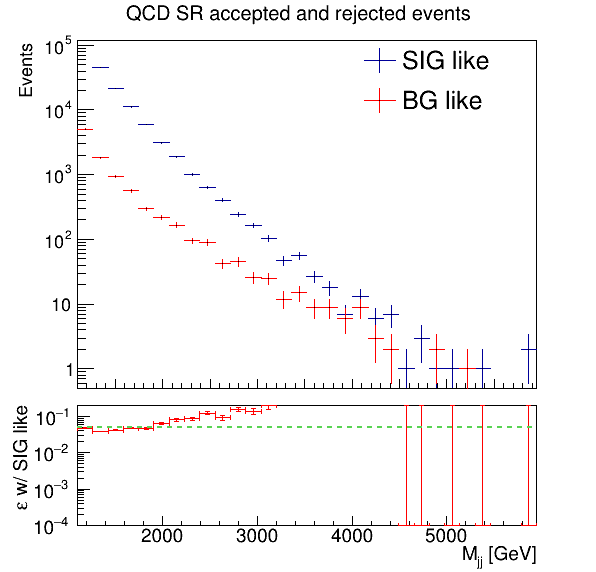

In [8]:
Mjj_selection = 1100.
binning=[30, Mjj_selection, qcd_sig_sample[mjj_key].max()]
an.plot_mass_spectrum_ratio(qcd_sig_sample.accepted(mjj_key), qcd_sig_sample.rejected(mjj_key), binning, quantile, 'QCD SR accepted and rejected events')

plot losses (reco vs kl) for accepted and rejected sample

In [36]:
from importlib import reload
reload(pu)
reload(js)
import anpofah.util.data_preprocessing as dpr
reload(dpr)

<module 'anpofah.util.data_preprocessing' from '/eos/home-k/kiwoznia/dev/analysis_physics_objects/anpofah/util/data_preprocessing.py'>

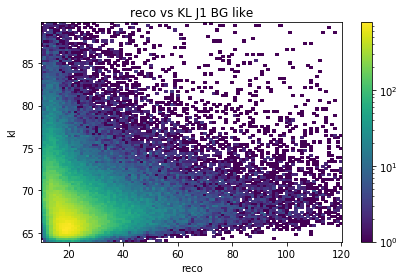

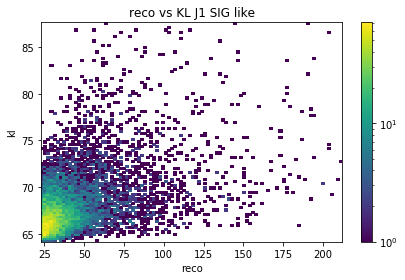

In [37]:
# plot BG like
pu.plot_hist_2d(qcd_sig_sample.rejected('j1RecoLoss'),qcd_sig_sample.rejected('j1KlLoss'), xlabel='reco', ylabel='kl', title='reco vs KL J1 BG like', clip_outlier=True)
pu.plot_hist_2d(qcd_sig_sample.accepted('j1RecoLoss'),qcd_sig_sample.accepted('j1KlLoss'), xlabel='reco', ylabel='kl', title='reco vs KL J1 SIG like', clip_outlier=True)